In [1]:
import pandas as pd
import numpy as np

/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('train_rmvnan_0207_ver1.csv')
df

/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_16158/92164939.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_rmvnan_0207_ver1.csv')


,fullVisitorId,date,visitId,visitNumber,visitStartTime,channelGrouping,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,...,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_isTrueDirect,trafficSource_referralPath,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_adContent
0,1131660440785968503,2016-09-02,1472830385,1,2016-09-02 15:33:05,Organic Search,Chrome,Windows,False,desktop,...,google,organic,(not provided),NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,377306020877927890,2016-09-03,1472880147,1,2016-09-03 05:22:27,Organic Search,Firefox,Macintosh,False,desktop,...,google,organic,(not provided),NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,3895546263509774583,2016-09-03,1472865386,1,2016-09-03 01:16:26,Organic Search,Chrome,Windows,False,desktop,...,google,organic,(not provided),NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,4763447161404445595,2016-09-03,1472881213,1,2016-09-03 05:40:13,Organic Search,UC Browser,Linux,False,desktop,...,google,organic,google + online,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,27294437909732085,2016-09-02,1472822600,2,2016-09-02 13:23:20,Organic Search,Chrome,Android,True,mobile,...,google,organic,(not provided),True,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,5123779100307500332,2017-01-04,1483554750,1,2017-01-04 18:32:30,Social,Chrome,Windows,False,desktop,...,youtube.com,referral,NaN,NaN,/yt/about/,0.0,NaN,NaN,NaN,NaN
903649,7231728964973959842,2017-01-04,1483543798,1,2017-01-04 15:29:58,Social,Chrome,Android,True,mobile,...,youtube.com,referral,NaN,NaN,/yt/about/,0.0,NaN,NaN,NaN,NaN
903650,5744576632396406899,2017-01-04,1483526434,1,2017-01-04 10:40:34,Social,Android Webview,Android,True,mobile,...,youtube.com,referral,NaN,NaN,/yt/about/ko/,0.0,NaN,NaN,NaN,NaN
903651,2709355455991750775,2017-01-05,1483592857,1,2017-01-05 05:07:44,Social,Chrome,Windows,False,desktop,...,facebook.com,referral,NaN,NaN,/l.php,0.0,NaN,NaN,NaN,NaN


- 첫 접속과 마지막 접속 사이의 길이 : 평균 접속 시간

In [6]:
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], format='%Y-%m-%d %H:%M:%S')
mean_s = df.groupby(['date', 'fullVisitorId'])['visitStartTime'].agg(['min', 'max']).diff(axis=1)

In [7]:
mean_s['diff'] = mean_s['max'].dt.total_seconds()

# min = max 데이터는 제거. 0보다 커야 함.
mean_s = mean_s[mean_s['diff'] > 0]

se_mean = mean_s.groupby('fullVisitorId')['diff'].mean().to_frame()

In [8]:
import seaborn as sns

/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


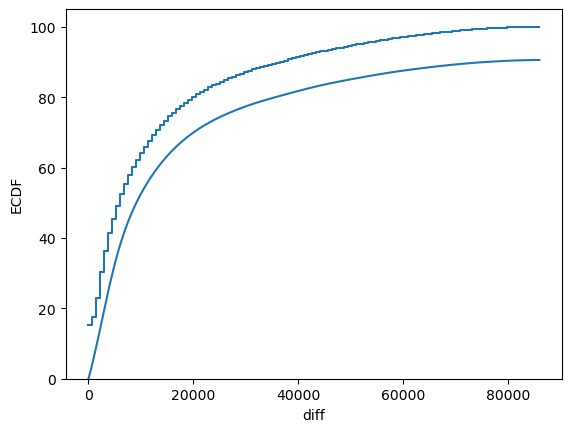

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'stat'을 'percent'로 지정하여 ECDF를 얻음
# 'element'로 'step'을 사용하여 계단식 그래프를 생성
sns.histplot(se_mean, x='diff', cumulative=True, stat='percent', element='step', fill=False, kde=True)
plt.xlabel('diff')
plt.ylabel('ECDF')
plt.show()


# 세션 간의 시간차가 30분 미만일 때, 두 이벤트는 같은 세션으로 간주한다.

In [13]:
tm_id = df[['fullVisitorId','visitStartTime']].sort_values(['fullVisitorId','visitStartTime'])

In [14]:
tm_diff = tm_id.groupby('fullVisitorId')['visitStartTime'].diff().to_frame()

In [15]:
tm_diff.columns = ['sess_diff']

In [16]:
diff = tm_id.merge(tm_diff,how='outer',left_index=True, right_index=True)

In [17]:
diff['sess_diff'] = diff['sess_diff'].dt.total_seconds()

In [18]:
same_diff = diff[diff.sess_diff < 1800]

In [19]:
same_diff_mean = same_diff.groupby('fullVisitorId').sess_diff.mean().to_frame()

In [20]:
same_diff_mean.describe()

,sess_diff
count,10714.000000
mean,343.441866
std,415.953055
min,1.000000
25%,48.000000
50%,167.750000
75%,482.875000
max,1798.000000


/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


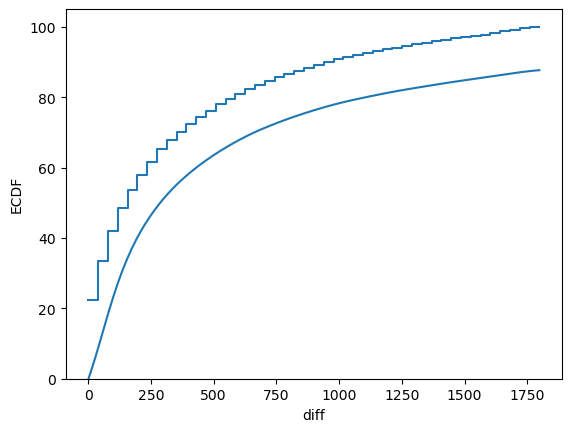

In [22]:
sns.histplot(same_diff_mean, x='sess_diff', cumulative=True, stat='percent', element='step', fill=False, kde=True)
plt.xlabel('diff')
plt.ylabel('ECDF')
plt.show()